In [25]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_wine
from sklearn.preprocessing import StandardScaler
import random
import matplotlib.pyplot as plt

plt.rcParams['axes.grid'] = False

import matplotlib as mpl
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from scipy.stats import spearmanr, pearsonr, entropy
import libpysal
from esda.moran import Moran
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon

import scipy.stats
from fastcluster import linkage
from scipy.spatial.distance import squareform, pdist
from matplotlib.patches import Ellipse
import scipy.linalg as linalg
import numpy.linalg as la
import seaborn as sns

from skimage import measure

import matplotlib.gridspec as gridspec
from scipy.stats import gaussian_kde

import h5py

import torch
import torch.nn as nn
import torch.optim as optim

from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from mpl_toolkits.axes_grid1 import make_axes_locatable

import warnings
warnings.filterwarnings('ignore')

Assess how "sensitive" your autoencoder is to its initialization and get a sense of how stable the learned embeddings are across different training runs. This approach is especially valuable in research or in situations where reproducibility and stability of the model are crucial.

In [2]:
def box_plot(dictionary, var_name, value_name, save_title, box_width=0.8, xlabel_rot=0):

    # Make dataframe from dictionary
    df = pd.DataFrame(dictionary)

    # Melt the DataFrame to reshape it
    df = pd.melt(df, var_name=var_name, value_name=value_name)

    mpl.rcParams['figure.dpi'] = 500
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.figure(figsize=(4,3))
    sns.boxplot(data = df, x=var_name, y=value_name, boxprops=dict(alpha=.9),palette="muted",linewidth=0.7,fliersize=0.9, width=box_width)
    plt.ylabel(value_name,fontsize=10)
    plt.xlabel('')
    plt.xticks(rotation=xlabel_rot)
    plt.savefig(save_title+'.tiff', dpi=300, bbox_inches='tight')
    plt.show(block=False)
    return

In [3]:
def percentage_change(measure, data_type):

    """
    Finds the percentage change in any measure of choice for each consecutive pair of AE realizations
    :param realizations:
    :return:
    """
    changes = []

    if data_type.lower() == 'list':
        for i in range(0, len(measure)):
            prev_set = set(measure[i - 1])
            current_set = set(measure[i])
            changed_elements = current_set.symmetric_difference(prev_set)
            total_elements = len(prev_set.union(current_set))
            change = len(changed_elements) / total_elements * 100
            changes.append(change)

    elif data_type.lower() == 'numpy':
        for i in range(0, len(measure)):
            prev_row = measure[i - 1]
            current_row = measure[i]
            change = np.abs((current_row - prev_row) / prev_row) * 100
            changes.append(change)

    return changes

Note that this function is a sequential comparison and not comprehensive across all AE realization pairs. If you want a global stability/instability view, then consider the Jaccard similarity instead or MC approach.

The sequential change in percentages is useful for understanding the immediate stability of the model from one realization to the next. It can highlight how sensitive the model is to small changes in the random seed or initialization parameters. On the other hand, the Jaccard similarity across all pairs of realizations offers a broader view of overall stability and consistency across the entire range of realizations.

In [4]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    """
    This function checks if the distance matrix is symmetric, prior to making a sorted dissimilarity matrix
    """
    return np.allclose(a, a.T, rtol=rtol, atol=atol)


def seriation(Z, N, cur_index):
    """
    This is a function that creates a sorted 2D matrix as a figure

        input:
            - Z is a hierarchical tree (dendrogram)
            - N is the number of points given to the clustering process
            - cur_index is the position in the tree for the recursive traversal
        output:
            - order implied by the hierarchical tree Z

        seriation computes the order implied by a hierarchical tree (dendrogram)
    """

    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index - N, 0])
        right = int(Z[cur_index - N, 1])
        return seriation(Z, N, left) + seriation(Z, N, right)


def compute_serial_matrix(dist_mat, method="ward"):
    """
        input:
            - dist_mat is a distance matrix
            -  = ["ward","single","average","complete"]
        output:
            - seriated_dist is the input dist_mat,
              but with re-ordered rows and columns
              according to the seriation, i.e. the
              order implied by the hierarchical tree
            - res_order is the order implied by
              the hierarchical tree
            - res_linkage is the hierarchical tree (dendrogram)

        compute_serial_matrix transforms a distance matrix into
        a sorted distance matrix according to the order implied
        by the hierarchical tree (dendrogram)
    """

    N = len(dist_mat)
    flat_dist_mat = dist_mat if len(dist_mat.shape) == 2 else squareform(dist_mat)
    res_linkage = linkage(flat_dist_mat, method=method, preserve_input=True)
    res_order = seriation(res_linkage, N, N + N - 2)
    seriated_dist = np.zeros((N, N))
    a, b = np.triu_indices(N, k=1)
    seriated_dist[a, b] = dist_mat[[res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b, a] = seriated_dist[a, b]

    return seriated_dist, res_order, res_linkage

In [5]:
def mvee(points, tol=0.0001):
    """
    Finds the ellipse equation in "center form"
    (x-c).T * A * (x-c) = 1
    """
    N, d = points.shape
    Q = np.column_stack((points, np.ones(N))).T
    err = tol+1.0
    u = np.ones(N)/N
    while err > tol:
        # assert u.sum() == 1 # invariant
        X = np.dot(np.dot(Q, np.diag(u)), Q.T)
        M = np.diag(np.dot(np.dot(Q.T, la.inv(X)), Q))
        jdx = np.argmax(M)
        step_size = (M[jdx]-d-1.0)/((d+1)*(M[jdx]-1.0))
        new_u = (1-step_size)*u
        new_u[jdx] += step_size
        err = la.norm(new_u-u)
        u = new_u
    c = np.dot(u, points)
    A = la.inv(np.dot(np.dot(points.T, np.diag(u)), points)
               - np.multiply.outer(c, c))/d
    return A, c


def dist_2_cent(x, y, center):
    '''
    Obtain distance to center coordinates for the entire x,y array passed.
    '''

    # delta_x, delta_y = abs(x - center[0]), abs(y - center[1])
    delta_x, delta_y = (x - center[0]), (y - center[1])
    dist = np.sqrt(delta_x ** 2 + delta_y ** 2)

    return delta_x, delta_y, dist


def get_outer_shell(center, x, y):
    '''
    Selects those stars located in an 'outer shell' of the points cloud,
    according to a given accuracy (ie: the 'delta_angle' of the slices the
    circle is divided in).
    '''

    delta_x, delta_y, dist = dist_2_cent(x, y, center)

    # Obtain correct angle with positive x axis for each point.
    angles = []
    for dx, dy in zip(*[delta_x, delta_y]):
        ang = np.rad2deg(np.arctan(abs(dx / dy)))
        if dx > 0. and dy > 0.:
            angles.append(ang)
        elif dx < 0. and dy > 0.:
            angles.append(180. - ang)
        elif dx < 0. and dy < 0.:
            angles.append(270. - ang)
        elif dx > 0. and dy < 0.:
            angles.append(360. - ang)

    # Get indexes of angles from min to max value.
    min_max_ind = np.argsort(angles)

    # Determine sliced circumference. 'delta_angle' sets the number of slices.
    delta_angle = 1.
    circle_slices = np.arange(delta_angle, 361., delta_angle)

    # Fill outer shell with as many empty lists as slices.
    outer_shell = [[] for _ in range(len(circle_slices))]
    # Initialize first angle value (0\degrees) and index of stars in list
    # ordered from min to max distance value to center.
    ang_slice_prev, j = 0., 0
    # For each slice.
    for k, ang_slice in enumerate(circle_slices):
        # Initialize previous maximum distance and counter of stars that have
        # been processed 'p'.
        dist_old, p = 0., 0
        # For each star in the list, except those already processed (ie: with
        # an angle smaller than 'ang_slice_prev')
        for i in min_max_ind[j:]:
            # If the angle is within the slice.
            if ang_slice_prev <= angles[i] < ang_slice:
                # Increase the index that stores the number of stars processed.
                p += 1
                # If the distance to the center is greater than the previous
                # one found (if any).
                if dist[i] > dist_old:
                    # Store coordinates of new star farthest away from center
                    # in this slice.
                    outer_shell[k] = [x[i], y[i]]
                    # Re-assign previous max distance value.
                    dist_old = dist[i]
            # If the angle value is greater than the max slice value.
            elif angles[i] >= ang_slice:
                # Increase index of last star processed and break out of
                # stars loop.
                j += p
                break

        # Re-assign minimum slice angle value.
        ang_slice_prev = ang_slice

    # Remove empty lists from array (ie: slices with no stars in it).
    outer_shell = np.asarray([x for x in outer_shell if x != []])

    return outer_shell


def random_points():
    mu, sigma = np.random.uniform(-10, 10), np.random.uniform(0., 10)
    return mu, sigma


def run_mvee(array_2d, plotter=True):

    # # Generate some random points to test
    # N = 2000
    # mux, sigmax = random_points()
    # muy, sigmay = random_points()
    # x = np.random.normal(mux, sigmax, N)
    # y = np.random.normal(muy, sigmay, N)
    # center = [mux, muy]
    # points = get_outer_shell(center, x, y)

    # center the 2d array at 0.0 i.e., mean centering
    data_array = array_2d - np.mean(array_2d, axis=0)

    # Extract x and y coordinates from mean centered array
    x, y = data_array[:, 0], data_array[:, 1]

    # Use the centroid of data as the initial center for get_outer_shell
    center = [np.mean(x), np.mean(y)]
    points = get_outer_shell(center, x, y)

    # Run the MVEE algorithm
    A, centroid = mvee(points)

    # Extract ellipse parameters
    U, D, V = la.svd(A)
    rx, ry = 1./np.sqrt(D)
    dx, dy = 2 * rx, 2 * ry
    a, b = max(dx, dy), min(dx, dy)
    mvee_anis = a/b
    alpha = np.rad2deg(np.arccos(V[0][1]))

    if plotter:
        fig, ax = plt.subplots()
        ax.scatter(x, y, s=10, zorder=4)
        ax.scatter(points[:, 0], points[:, 1], s=75, c='r', zorder=3)
        ax.scatter(*centroid, s=70, c='g')
        ax.scatter(center[0], center[1], c='k', s=70)
        ellipse = Ellipse(xy=centroid, width=a, height=b, edgecolor='k',
                          angle=alpha, fc='None', lw=2)
        plt.savefig('MVEE Anisotropy Plot.tiff', dpi=300, bbox_inches='tight')
        ax.add_patch(ellipse)
        plt.show(block=False)
    return mvee_anis

In [6]:
def compute_anisotropy(array_2d, type, plotter=True):

    # Initialize variables
    global_anis = None
    local_anis = []
    arithmetic_anis = None
    harmonic_anis = None
    geometric_anis = None

    # Perform mean centering to 0 on array
    temp = array_2d.copy()
    data = temp - np.mean(temp, axis=0)
    center = np.mean(data, axis=0)

    # Estimate the PDF using Gaussian Kernel Density Estimation
    kde = gaussian_kde(data.T)
    x_grid, y_grid = np.mgrid[data[:,0].min():data[:,0].max():100j, data[:,1].min():data[:,1].max():100j]
    pdf_values = kde(np.vstack([x_grid.ravel(), y_grid.ravel()]))

    # Reshape for contour plot
    pdf_values = pdf_values.reshape(x_grid.shape)

    # Make the plot
    if plotter:
        # # Plotting the PDF and data
        # fig, ax = plt.subplots()
        # ax.imshow(np.rot90(pdf_values), cmap=plt.cm.gist_earth_r, extent=[x_grid.min(), x_grid.max(), y_grid.min(), y_grid.max()])
        # ax.scatter(center[0], center[1], c='r', s=2)
        # ax.plot(data[:, 0], data[:, 1], 'k.', markersize=2)
        # Create a grid layout for the plots

        fig = plt.figure(figsize=(8, 8))
        gs = gridspec.GridSpec(4, 4)

        # Main scatter plot
        ax_main = plt.subplot(gs[1:4, 0:3])
        ax_main.imshow(np.rot90(pdf_values), cmap=plt.cm.gist_earth_r, extent=[x_grid.min(), x_grid.max(), y_grid.min(), y_grid.max()])
        ax_main.scatter(center[0], center[1], c='r', s=2)
        ax_main.plot(data[:, 0], data[:, 1], 'k.', markersize=2)
        ax_main.set_xlabel('LS 1')
        ax_main.set_ylabel('LS 2')

        # Marginal distributions
        ax_xDist = plt.subplot(gs[0, 0:3], sharex=ax_main)
        ax_yDist = plt.subplot(gs[1:4, 3], sharey=ax_main)

        # # Plotting marginal distributions as histograms
        # ax_xDist.hist(data[:, 0], bins=30, orientation='vertical', color='blue')
        # ax_xDist.set_ylabel('Frequency (LS 1)')
        #
        # ax_yDist.hist(data[:, 1], bins=30, orientation='horizontal', color='blue')
        # ax_yDist.set_xlabel('Frequency (LS 2)')

        # Plotting marginal distributions as KDE's
        kde_x = gaussian_kde(data[:, 0])
        x_line = np.linspace(data[:, 0].min(), data[:, 0].max(), 100)
        ax_xDist.plot(x_line, kde_x(x_line), color='blue')
        ax_xDist.set_ylabel('Density (LS 1)')

        kde_y = gaussian_kde(data[:, 1])
        y_line = np.linspace(data[:, 1].min(), data[:, 1].max(), 100)
        ax_yDist.plot(kde_y(y_line), y_line, color='blue')
        ax_yDist.set_xlabel('Density (LS 2)')

        # Turn off ticks for marginal distributions
        ax_xDist.xaxis.set_tick_params(labelbottom=False)
        ax_yDist.yaxis.set_tick_params(labelleft=False)

    if type.lower() == 'global':
        # Compute covariance matrix for the entire dataset
        cov = np.cov(data.T)
        eigenvalues, eigenvectors = linalg.eigh(cov)
        order = eigenvalues.argsort()[::-1]
        eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
        angle = np.degrees(np.arctan2(*eigenvectors[:, 0][::-1]))

        # Ellipse parameters for the entire dataset
        width, height = 2 * np.sqrt(eigenvalues)
        overall_ellipse = Ellipse(xy=np.mean(data, axis=0), width=width, height=height, angle=angle, edgecolor='red', fc='None', lw=2)

        # Compute anisotropy global
        global_anis = width / height

    elif type.lower() == 'local':
        # Contour level at 95% confidence interval
        level = np.percentile(pdf_values, 95)

        if plotter:
            # Find and fit ellipses to all such contours, which is indicative of tentative cluster structures within an array if any
            for path in ax_main.contour(x_grid, y_grid, pdf_values, levels=[level], colors='r').collections[0].get_paths():
                v = path.vertices
                cov = np.cov(v, rowvar=False)
                eigenvalues, eigenvectors = linalg.eigh(cov)
                order = eigenvalues.argsort()[::-1]
                eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
                angle = np.arctan2(*eigenvectors[:, 0][::-1])
                width, height = 2 * np.sqrt(eigenvalues)
                ellipse = Ellipse(xy=np.mean(v, axis=0), width=width, height=height, angle=np.degrees(angle), edgecolor='b', fc='None')

                # Add each ellipse to the plot
                if plotter:
                    #ax.add_patch(ellipse)
                    ax_main.add_patch(ellipse)

                # Compute local anisotropies with respect to bi or multimodal pdf's and save
                local_anis.append(width / height)
        else:
            # Find and fit ellipses to all such contours, which is indicative of tentative cluster structures within an array if any
            # for path in plt.contour(x_grid, y_grid, pdf_values, levels=[level], colors='r').collections[0].get_paths():
            #     v = path.vertices
            contours = measure.find_contours(pdf_values, level=level)
            for contour in contours:
                v = contour
                cov = np.cov(v, rowvar=False)
                eigenvalues, eigenvectors = linalg.eigh(cov)
                order = eigenvalues.argsort()[::-1]
                eigenvalues, eigenvectors = eigenvalues[order], eigenvectors[:, order]
                angle = np.arctan2(*eigenvectors[:, 0][::-1])
                width, height = 2 * np.sqrt(eigenvalues)
                ellipse = Ellipse(xy=np.mean(v, axis=0), width=width, height=height, angle=np.degrees(angle), edgecolor='b', fc='None')

                # Compute local anisotropies with respect to bi or multimodal pdf's and save
                local_anis.append(width / height)

    # Compute the harmonic and geometric means of the local anisotropy
    arithmetic_anis = np.mean(local_anis) if local_anis else None
    harmonic_anis = scipy.stats.hmean(local_anis) if local_anis else None
    geometric_anis = scipy.stats.gmean(local_anis) if local_anis else None

    if  plotter and type.lower() == 'global':
        #ax.add_patch(overall_ellipse)
        ax_main.add_patch(overall_ellipse)

    if plotter:
        plt.savefig('Local or Global Anisotropy.tiff', dpi=300, bbox_inches='tight')
        plt.show(block=False)
    return global_anis, local_anis, arithmetic_anis, harmonic_anis, geometric_anis

In [7]:
def modified_raw_stress(embeddings1, embeddings2):
    """
    Compute raw stress between two sets of embeddings using Euclidean distance on a point by point basis

    Args:
        embeddings1 (numpy.ndarray): Array of embeddings from the first autoencoder.
        embeddings2 (numpy.ndarray): Array of embeddings from the second autoencoder.

    Returns:
        float: Stress value indicating dissimilarity between the embeddings.
    """
    # Ensure the embeddings have the same shape
    if embeddings1.shape != embeddings2.shape:
        raise ValueError("Embeddings must have the same shape")

    squared_diff = np.sum((embeddings1 - embeddings2)**2, axis=1)

    stress = np.mean(np.sqrt(squared_diff))
    return stress

In [8]:
def modified_norm_stress(embeddings1, embeddings2):
    """
    Compute normalized adjusted stress between two sets of embeddings on a structural basis

    Args:
        embeddings1 (numpy.ndarray): Array of embeddings from the first autoencoder.
        embeddings2 (numpy.ndarray): Array of embeddings from the second autoencoder.

    Returns:
        float: Adjusted MDS stress indicating dissimilarity between the embeddings.
    """
    # Ensure the embeddings have the same shape
    if embeddings1.shape != embeddings2.shape:
        raise ValueError("Embeddings must have the same shape")

    dists1 = squareform(pdist(embeddings1, 'euclidean'))
    dists2 = squareform(pdist(embeddings2, 'euclidean'))

    numerator = np.sum((dists1 - dists2) ** 2)
    denominator = np.sum(dists1 ** 2)

    if denominator == 0:
        return 0.0

    stress = np.sqrt(numerator / denominator)
    return stress

In [9]:
def adjusted_stress(embeddings1, embeddings2):
    """
    Compute normalized adjusted stress between two sets of embeddings on a structural basis

    Args:
        embeddings1 (numpy.ndarray): Array of embeddings from the first autoencoder.
        embeddings2 (numpy.ndarray): Array of embeddings from the second autoencoder.

    Returns:
        float: Adjusted MDS stress indicating dissimilarity between the embeddings.
    """
    # Ensure the embeddings have the same shape
    if embeddings1.shape != embeddings2.shape:
        raise ValueError("Embeddings must have the same shape")

    dists1 = squareform(pdist(embeddings1, 'euclidean'))
    dists2 = squareform(pdist(embeddings2, 'euclidean'))

    numerator = np.sum((dists1 - dists2) ** 2)
    denominator = np.sum(dists1 * dists2)

    if denominator == 0:
        return 0.0

    stress = np.sqrt(numerator / denominator)
    return stress

In [10]:
data = load_wine()
target = load_wine().target
df = pd.DataFrame(data.data, columns=data.feature_names)
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

In [11]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], idx

In [12]:
num_epochs = 2000
batch_size = 16
#dataset = torch.tensor(df_scaled, dtype=torch.float32)
dataset = CustomDataset(torch.tensor(df_scaled, dtype=torch.float32))

In [13]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, encoding_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 128),
            nn.LeakyReLU(),
            nn.Linear(128, input_dim)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [14]:
input_dim = df.shape[1]
encoding_dim = 2
model = Autoencoder(input_dim, encoding_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

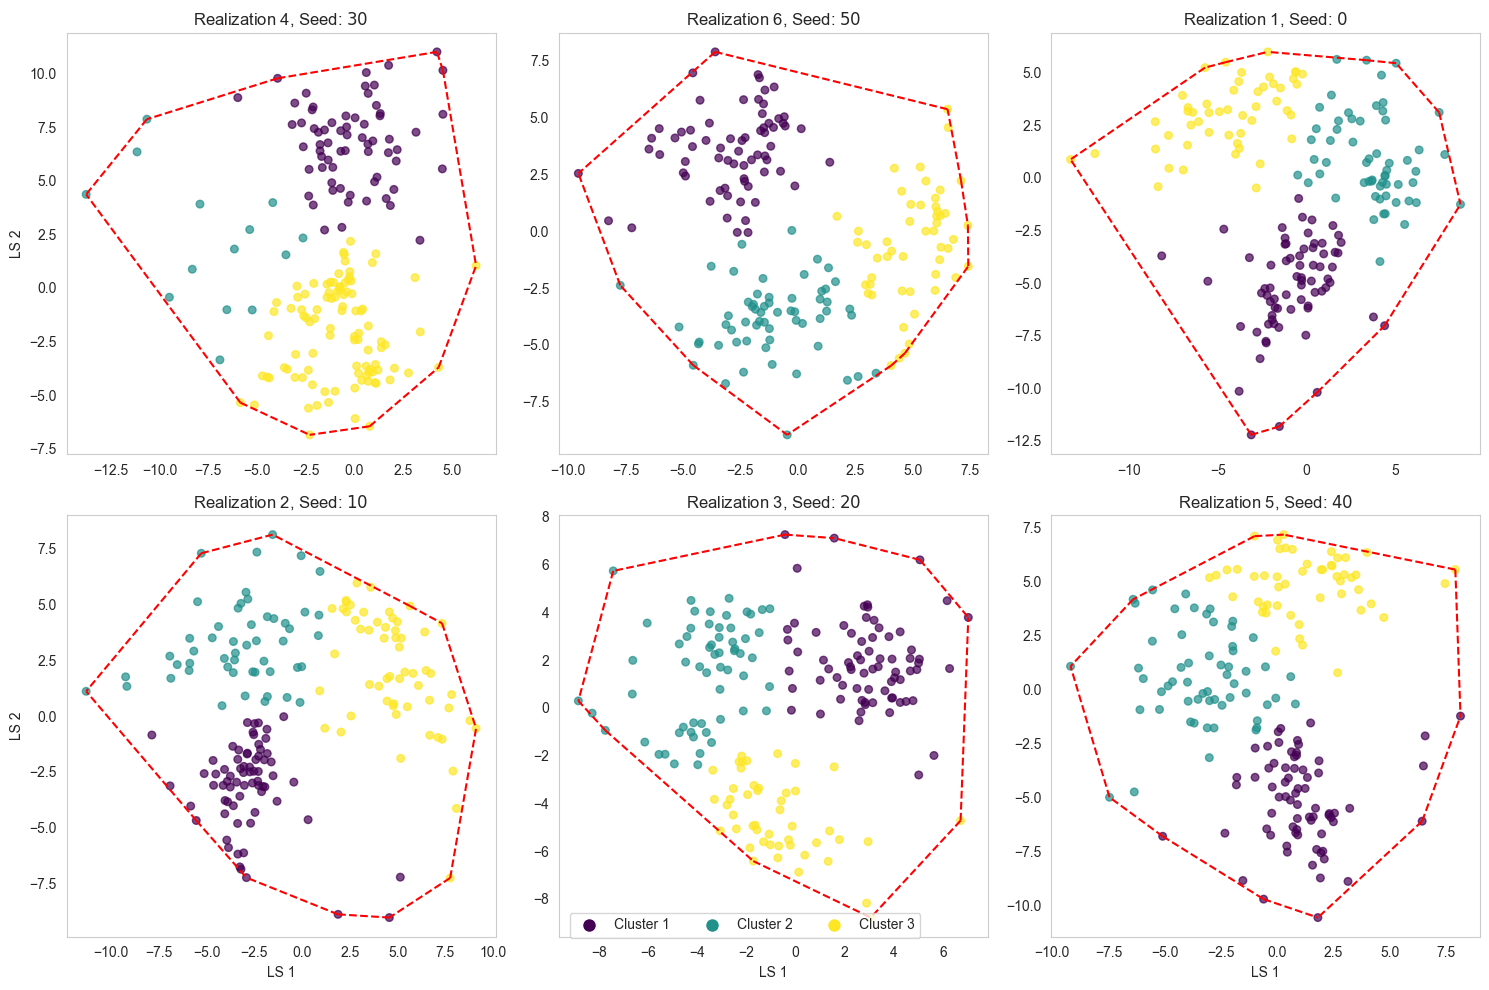

In [15]:
initial_seed = 0 # starting sequence for random seed generator
step_size = 10   # Change this to increase seeds every x units as needed
random.seed(initial_seed)
num_seeds = 6 # 100 # 1000 # nos of realizations needed
seed_values = [initial_seed + (step_size * i) for i in range(num_seeds)]
cluster_changes = np.zeros_like(target)  # To track changes in cluster assignments
change_percentages = []  # List to store percentage of changed clusters for each realization
statistics_array = np.empty((num_seeds, 7))
pvalues_array = np.empty((num_seeds, 3))
convexhull_array = np.empty((num_seeds, 3))
anisotropy_array = np.empty((num_seeds, 5))
convex_hull_vertices = []
all_loss_curves = []
local_anisotropies = []
hdf5_file = 'embedding_realizations.h5' # store each latent space for all AE realizations here

# Make the HDF5 file
with h5py.File(hdf5_file, 'w') as f:
    pass  # Just to create the file

# Make 3x3 subplot for 6 randomly selected AE realizations visualizations
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()
random.seed(initial_seed)
visualization_indices = random.sample(range(num_seeds), 6)

for idx, seed in enumerate(seed_values):
    torch.manual_seed(seed)
    random.seed(seed)
    generator = torch.Generator().manual_seed(seed)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, generator=generator)

    model = Autoencoder(input_dim, encoding_dim)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    epoch_losses = []
    for epoch in range(num_epochs):
        total_loss = 0
        #for data in dataloader:
        for data, indices in dataloader:
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, data)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        epoch_losses.append(total_loss / len(dataloader))
    all_loss_curves.append(epoch_losses)

################################################ SELF NOTE #############################################################################################################
#     # Clustering in latent space
#     Here's a breakdown of how it works:
#
# 1. **Initialization**:
#    - `cluster_changes` is initialized as a zero array with the same shape as the `target` (truth labels). This means initially, all data points have 0 changes.
#    - `predicted_clusters` is computed for each realization after clustering in the latent space.
#
# 2. **Matching clusters with truth labels**:
#    - A cost matrix is computed to find the best correspondence between predicted clusters and the true labels.
#    - The Hungarian algorithm (`linear_sum_assignment`) is used to determine the optimal assignment.
#    - After the best assignment is determined, `predicted_clusters` labels are rearranged to match the true labels as closely as possible.
#
# 3. **Tracking changes**:
#    - For each data point, if its assigned cluster (`predicted_clusters`) doesn't match its true label (`target`), its corresponding value in `cluster_changes` is incremented by 1.
#    - This process is repeated for all realizations.
########################################################################################################################################################################


    # with torch.no_grad():
    #     encoded_data = model.encoder(dataset).numpy()

    # Reorder the embeddings gotten based on the originlal data index
    with torch.no_grad():
        encoded_data, original_indices = zip(*[(model.encoder(d[None, ...]), idx) for d, idx in dataset])
        # Reordering step here
        encoded_data = torch.cat(encoded_data, dim=0).numpy()
        order = np.argsort(original_indices)
        encoded_data = encoded_data[order]

        # Save each latent space embeddings to an HDF5 file
        with h5py.File(hdf5_file, 'a') as f:
            f.create_dataset(f'embedding_realizations_{idx}', data=encoded_data)


################################################ SELF NOTE #############################################################################################################
# The CustomDataset class returns both the data and its index. When shuffled in the DataLoader, the indices will follow the same shuffling order as the data.
# During training, you get both data and indices from the DataLoader. However, the indices are not used in training; they're only needed for evaluation.

    # When evaluating, you need to reorder the embeddings according to the original indices. This is done by first getting the embeddings and their original indices, and then using np.argsort to reorder the embeddings to match the original data order.

    # This approach ensures that, despite shuffling during training, you can align the embeddings from different autoencoders to their corresponding original data points. This alignment is crucial for comparing embeddings across different training runs with different seeds.
########################################################################################################################################################################


    kmeans = KMeans(n_clusters=3, n_init=10).fit(encoded_data)
    predicted_clusters = kmeans.labels_

    # Matching predicted clusters to true clusters
    cost_matrix = -np.array([[np.sum((predicted_clusters[true_indices] == pred_cluster))
                              for pred_cluster in range(3)]
                             for true_indices in [np.where(target == i)[0] for i in range(3)]])
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    for i in range(3):
        predicted_clusters[predicted_clusters == col_ind[i]] = -(i+10)  # Temporarily set to negative values
    for i in range(3):
        predicted_clusters[predicted_clusters == -(i+10)] = i

    changes = (predicted_clusters != target)
    change_percentages.append(100 * np.sum(changes) / len(target))
    cluster_changes += changes

    # Compute the chaos, global, and spatial statistics for each of the latent spaces for each AE realizations
    # Chaos Statistics
    array_flat = encoded_data.flatten()
    values, counts = np.unique(array_flat, return_counts=True)
    probabilities = counts / counts.sum()
    entropy_values = entropy(probabilities, base=2) # s1

    # Global Statistics
    mean_global = np.mean(encoded_data) # s2
    variance_global = np.var(encoded_data) # s3
    norm_fro = np.linalg.norm(encoded_data, 'fro') # s4
    pearson, coef_pval = pearsonr(encoded_data[:,0], encoded_data[:,1]) # s5
    spearman, rank_pval = spearmanr(encoded_data[:,0], encoded_data[:,1]) # s6

    # Spatial Statistics
    weights = libpysal.weights.lat2W(encoded_data.shape[0],encoded_data.shape[1], rook=False, id_type="float")
    np.random.seed(seed)

    mi = Moran(encoded_data, weights) # two_tailed=False for one tailed Moran, emeasure of overall spatial autocorrelation -1: perfect clustering of dissimilar values/objects (perfect dispersion), 0: perfect randomness, 1: perfect clustering of similar values/objects.
    moran = mi.I # s7
    moran_pval = mi.p_norm

    # Store the computed statistics in the array for this iteration
    statistics_array[idx, :] = [entropy_values, mean_global, variance_global, norm_fro, pearson, spearman, moran]
    pvalues_array[idx, :] = [coef_pval, rank_pval, moran_pval]

    # Save statistics and pvalues array to numpy files
    np.save('statistics_array.npy', statistics_array)
    np.save('pvalues_array.npy', pvalues_array)

    # Compute convex hull and associated attributes
    my_points = encoded_data.copy()
    hull = ConvexHull(my_points)
    vertices_idx = hull.vertices
    vertices = my_points[hull.vertices]
    polygon = Polygon(vertices)

    # Store computed variables needed from convex hull polygon i.e., the number of vertices, area, and volume for each AE realization
    convexhull_array[idx, :] = [len(vertices), hull.area, hull.volume]
    convex_hull_vertices.append(vertices_idx)

    # Save convex hull attributes to numpy files
    np.save('convexhull_array.npy', convexhull_array)

    # Different types of anisotropy computations
    mvee_anis= run_mvee(array_2d=encoded_data, plotter=False)
    global_anis, _, _, _, _ = compute_anisotropy(array_2d=encoded_data, type='global', plotter=False)
    _, local_anis, arithmetic_anis, harmonic_anis, geometric_anis = compute_anisotropy(array_2d=encoded_data, type='local', plotter=False)
    local_anisotropies.append(np.array(local_anis))
    anisotropy_array[idx, :] = [mvee_anis, global_anis, arithmetic_anis, harmonic_anis, geometric_anis]

    # Save and store anisotropy attributes to numpy files or whatever format as needed
    np.save('anisotropy_array.npy', anisotropy_array)

    # Check if the current realization index is in the list of visualization_indices
    if idx in visualization_indices:
        # Visualization of latent space in 3x3 grid
        scatter = axs[visualization_indices.index(idx)].scatter(encoded_data[:, 0], encoded_data[:, 1], c=predicted_clusters, cmap='viridis', marker='o', s=30,
                      alpha=0.7)
        axs[visualization_indices.index(idx)].set_title(f"Realization {idx + 1}, Seed: ${seed}$")

        for simplex in hull.simplices:
            axs[visualization_indices.index(idx)].plot(my_points[simplex, 0], my_points[simplex, 1], 'r--')
            #axs[visualization_indices.index(idx)].fill(my_points[hull.vertices, 0], my_points[hull.vertices, 1], c='yellow', alpha=0.01)

        # Adding Y-axis labels to the first column
        for ax in range(2):
            axs[ax * 3].set_ylabel("LS 2")

        # Adding X-axis label to the bottom row
        for ax in axs[3:]:
            ax.set_xlabel("LS 1")

        # Assuming the number of clusters is defined
        n_clusters = 3  # Example: 3 clusters
        viridis = ListedColormap(plt.cm.viridis(np.linspace(0, 1, n_clusters)))

        # Then, for each cluster, create a Line2D object for the legend
        legend_elements = [Line2D([0], [0], marker='o', color='w', label=f'Cluster {i+1}',
                                  markersize=10, markerfacecolor=viridis.colors[i]) for i in range(n_clusters)]

fig.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, 0.05), ncol=n_clusters)
plt.tight_layout()
plt.savefig('LS Visualization for Select AE Realizations with Convex Hull Line.png', dpi=300, bbox_inches='tight')
plt.show()

**Recall in each realization, we do the following:**

1. Train an autoencoder, and then applying k-means to the latent space to identify clusters.
2. These clusters are then matched to the true labels to minimize the discrepancies between predicted and true cluster assignments.
3. After matching, for each data point, if the matched predicted cluster is different from its true label, it's considered a "change", and the corresponding entry in `cluster_changes` is incremented.

The `cluster_changes` array accumulates these "changes" for each data point over all realizations. After all realizations are done, the value for a data point in `cluster_changes` represents how many times (out of all realizations) the predicted cluster for that data point didn't match its true label. This becomes a tell-tale sign of stability in the latent feature space.

The introduction of stochastic uncertainty through changing the random seed is a way to account for and analyze the variability in model training and performance. By training a model multiple times with different seeds, you can assess the robustness of the model and gain insights into how sensitive it is to variations in initialization and training data presentation. It helps in understanding the model's generalization and can be useful for hyperparameter tuning and model evaluation.


**Advantages of Minibatch Training for Small Datasets:**

1. Regularization: Minibatch training introduces noise into the training process, which can act as a form of regularization. This can help prevent overfitting, even on small datasets.
2. Efficiency: Minibatch training allows you to take advantage of parallelism, such as using GPUs, which can significantly speed up training even for small datasets.
3. Convergence: Minibatch training can lead to faster convergence, which means your model reaches a good solution more quickly.
4. Memory Efficiency: Training on the full dataset might not fit into memory, especially when the dataset is very large. Minibatch training allows you to work with smaller portions of the data at a time.

**Considerations for Minibatch Training on Small Datasets:**

1. Batch Size: When working with a small dataset, you should carefully choose the batch size. Very small batch sizes can introduce high variance in gradient updates, while very large batch sizes may not provide the regularization benefits of minibatch training. You may need to experiment to find the optimal batch size for your specific dataset and model.
2. Learning Rate: Smaller batch sizes may require smaller learning rates to prevent overshooting during optimization. Again, hyperparameter tuning may be necessary.
3. Validation Set: With a small dataset, it's crucial to have a validation set to monitor model performance. Overfitting can still occur, especially if your model has many parameters.
4. Data Augmentation: Data augmentation techniques (e.g., flipping, rotating, cropping) can help artificially increase the effective size of your dataset, making minibatch training more effective.
5. Transfer Learning: If your small dataset is similar to a larger dataset, you can consider using pre-trained models and fine-tuning them on your dataset.
6. In summary, while minibatch training can be beneficial for small datasets, it requires careful consideration of batch size, learning rate, and other hyperparameters. Additionally, techniques like data augmentation and transfer learning can be used to make the most of small datasets. Ultimately, the choice of whether to use minibatch training or not depends on the specific problem and constraints you are dealing with.


Idea of using the convex hull vertices to study the variability of inferences in different autoencoder realizations is quite innovative and can be a valuable approach. Here's why this could be beneficial and how you might go about it:


**Advantages of Using Convex Hull Vertices:**
1. Stability Analysis: By examining how the vertices of the convex hull change with different random seeds, you can assess the stability and robustness of the autoencoder. Consistent vertices across different realizations suggest that the autoencoder is reliably capturing the same underlying structure in the data.
2. Identifying Anchor Points: Convex hull vertices can serve as "anchor points" in your latent space, providing a way to understand the extremities or boundaries of the representations learned by the autoencoder.
3. Quantitative Analysis: Changes in the vertices can be quantified, allowing for a more systematic analysis of variability. Metrics like the distance between corresponding vertices in different realizations, or the area/volume of the convex hulls, can provide insights into the variability induced by different seeds.


**Implementing the Analysis:**
1. Compute Convex Hull: For each autoencoder realization, use the encoded latent space representations to compute the convex hull. Tools like scipy.spatial.ConvexHull in Python can be useful for this.
2. Compare Vertices: Analyze how the vertices of these convex hulls vary across different realizations. You might consider:
    * The position of vertices.
    * The number of vertices.
    * Geometric properties like the area or volume enclosed by the convex hull.
3. Statistical Analysis: Perform statistical tests or visualizations to understand the degree of variability. For instance, plotting the convex hulls from different realizations can visually show the differences.
4. Correlation with Seeds: Investigate if there's any pattern or correlation between the changes in the convex hull and the random seeds used. This might reveal how sensitive the autoencoder's latent space is to initialization.

**Considerations:**
1. Dimensionality: If your latent space is high-dimensional, the interpretation of convex hulls can become complex. Consider dimensionality reduction techniques for visualization and analysis.
2. Comparability: Ensure that the method used for comparing vertices is consistent and meaningful across different realizations.


In summary, using the convex hull vertices to analyze the impact of different random seeds on the latent space of an autoencoder is a promising approach. It can provide insights into the stability and variability of the autoencoder's learned representations, aiding in the understanding of how different initializations affect the model's inferences.


Visualize training loss for select AE realizations

The minimum loss for all AE realizations is:  0.13874289641777673


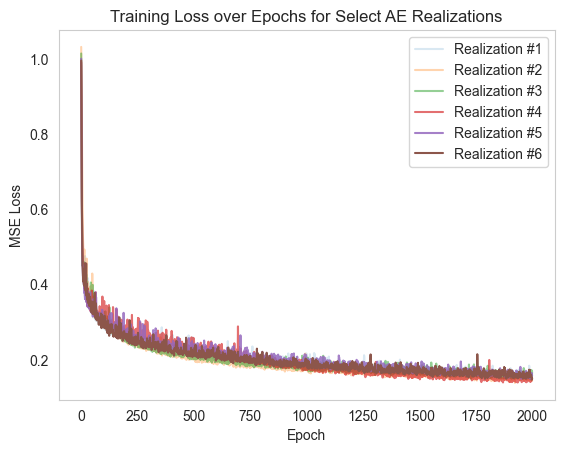

In [27]:
loss_val = np.min(all_loss_curves)
print('The minimum loss for all AE realizations is: ',loss_val)

# Generate alpha values within the range [0, 1]
alphas = [i/num_seeds for i in range(1, num_seeds + 1)]

# Visualize loss functions for select realizations
for idx, losses in enumerate(all_loss_curves):
    if idx in visualization_indices:
        plt.plot(losses, label=f'Realization #{idx+1}', alpha=alphas[idx])

plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training Loss over Epochs for Select AE Realizations')
plt.legend()
plt.savefig('Training loss over select realizations.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
# Compute the percentage changes in anchors found via convex hull
change_anchors = percentage_change(convex_hull_vertices, data_type='list')

# Compute the percentage changes in anisotropies found
change_mvee_anis = percentage_change(anisotropy_array[:,0], data_type='numpy')
change_global_anis = percentage_change(anisotropy_array[:,1], data_type='numpy')
change_arith_anis = percentage_change(anisotropy_array[:,2], data_type='numpy')
change_har_anis = percentage_change(anisotropy_array[:,3], data_type='numpy')
change_geo_anis = percentage_change(anisotropy_array[:,4], data_type='numpy')

In [23]:
# Insert function code for optimal bin size determination

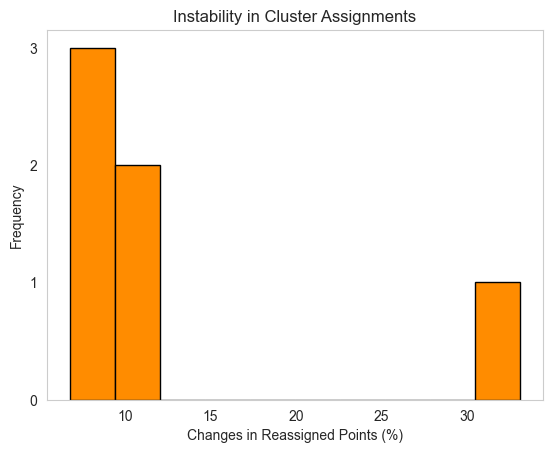

In [39]:
plt.hist(change_percentages, bins=10, color='darkorange', edgecolor='black')
plt.xlabel('Changes in Reassigned Points (%)')
plt.ylabel('Frequency')
plt.title('Instability in Cluster Assignments')
# plt.xticks(np.arange(0, num_seeds + 1, 100))
# plt.xlim([0, 100])  # Assuming the percentages are between 0 and 100
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
plt.savefig('Instability in Cluster Assignemnts.png', dpi=300, bbox_inches='tight')
plt.show()

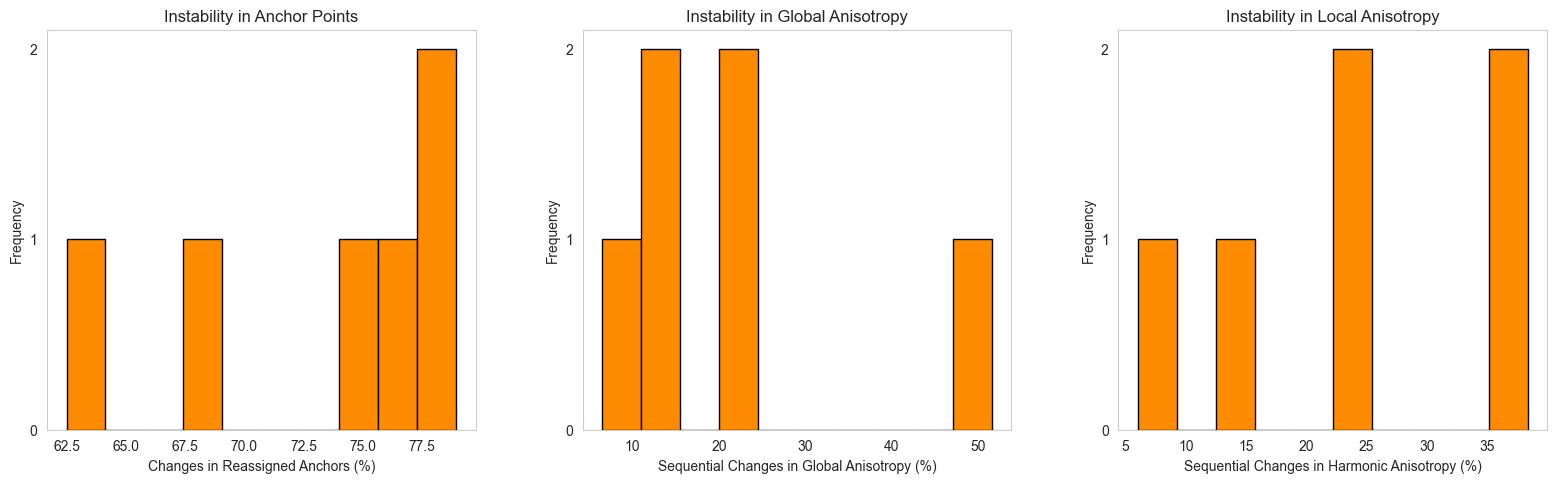

In [38]:
# Visualize percentage changes for shape-based statistics
fig, axs = plt.subplots(1, 3, figsize=(10, 4)) #-o

axs[0].hist(change_anchors, bins=10, color='darkorange', edgecolor='black')
axs[0].set_xlabel('Changes in Reassigned Anchors (%)')
axs[0].set_ylabel('Frequency')
axs[0].set_title('Instability in Anchor Points')
# axs[0].set_xticks(np.arange(0, num_seeds + 1, 100))
# axs[0].set_xlim([0, 100])  # Assuming the percentages are between 0 and 100
axs[0].yaxis.set_major_locator(MaxNLocator(integer=True))

axs[1].hist(change_global_anis, bins=10, color='darkorange', edgecolor='black')
axs[1].set_xlabel('Sequential Changes in Global Anisotropy (%)')
axs[1].set_ylabel('Frequency')
axs[1].set_title('Instability in Global Anisotropy')
# axs[1].set_xticks(np.arange(0, num_seeds + 1, 100))
# axs[1].set_xlim([0, 100])  # Assuming the percentages are between 0 and 100
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))

axs[2].hist(change_har_anis, bins=10, color='darkorange', edgecolor='black') # based off F1 score computation INSPO!
axs[2].set_xlabel('Sequential Changes in Harmonic Anisotropy (%)')
axs[2].set_ylabel('Frequency')
axs[2].set_title('Instability in Local Anisotropy')
# axs[2].set_xticks(np.arange(0, num_seeds + 1, 100))
# axs[2].set_xlim([0, 100])  # Assuming the percentages are between 0 and 100
axs[2].yaxis.set_major_locator(MaxNLocator(integer=True))

plt.subplots_adjust(left=0.0, bottom=0.3, right=1.5, top=1.3, wspace=0.25, hspace=0.3)
plt.savefig('Instability in Shape-based Statistics.png', dpi=300, bbox_inches='tight')
plt.show()

## Stress Computations

In [40]:
# Stress computation for unique pairs only
with h5py.File(hdf5_file, 'r') as f:
    N = len(f.keys())
    # Initialize matrices
    modified_norm_stress_matrix = np.zeros((N, N))
    modified_raw_stress_matrix = np.zeros((N, N))
    adjusted_stress_matrix = np.zeros((N, N))

    for i in range(N):
        embedding_i = f[f'embedding_realizations_{i}'][:]
        # scaler = StandardScaler()
        # embedding_i = scaler.fit_transform(embedding_i)
        for j in range(i + 1, N):  # Starting from i + 1 to avoid redundant computations
            embedding_j = f[f'embedding_realizations_{j}'][:]
            # scaler = StandardScaler()
            # embedding_j = scaler.fit_transform(embedding_j)

            # Compute modified norm stress
            norm_stress = modified_norm_stress(embedding_i, embedding_j)
            modified_norm_stress_matrix[i, j] = norm_stress
            modified_norm_stress_matrix[j, i] = norm_stress

            # Compute modified raw stress
            raw_stress = modified_raw_stress(embedding_i, embedding_j)
            modified_raw_stress_matrix[i, j] = raw_stress
            modified_raw_stress_matrix[j, i] = raw_stress

            # Compute adjusted raw_stress
            adj_stress = adjusted_stress(embedding_i, embedding_j)
            adjusted_stress_matrix[i, j] = adj_stress
            adjusted_stress_matrix[j, i] = adj_stress

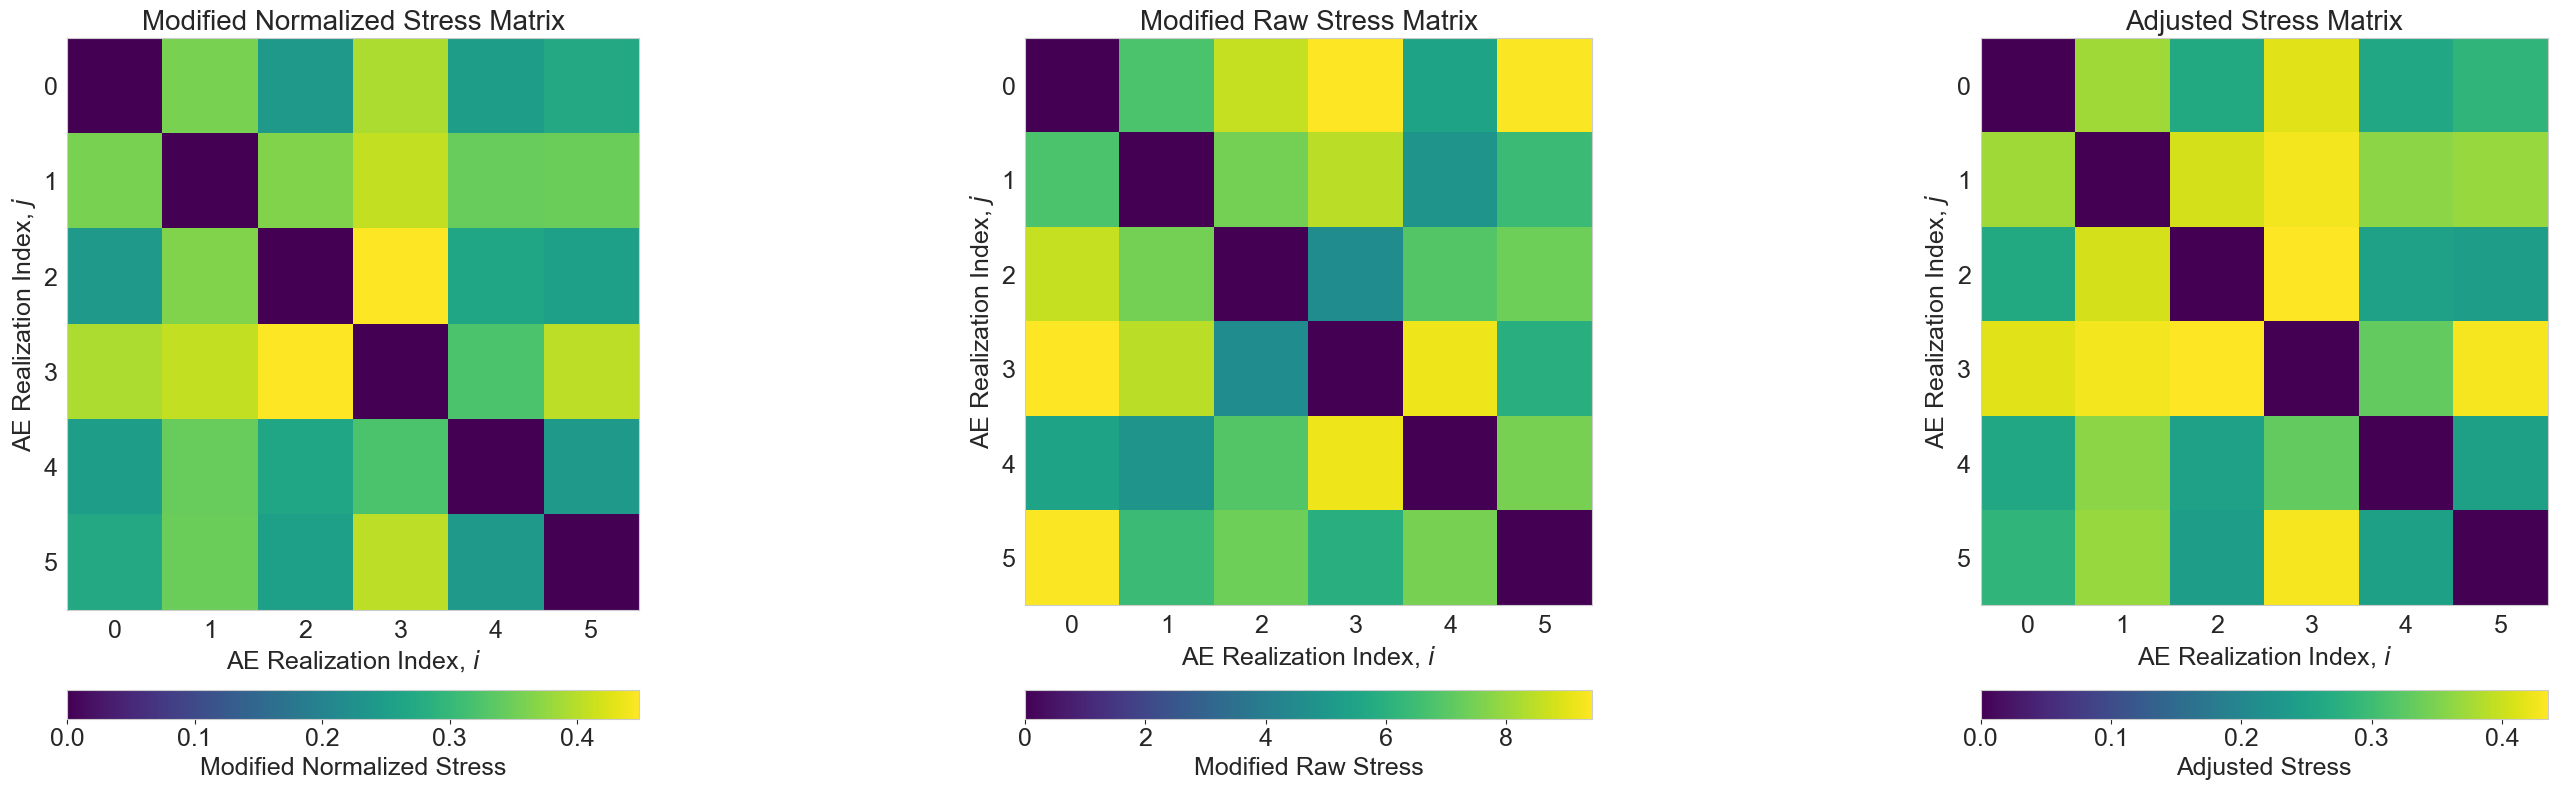

In [63]:
fig, axs = plt.subplots(1, 3, figsize=(30, 8))

# Modified normalized stress
im1 = axs[0].imshow(modified_norm_stress_matrix, cmap="viridis")
axs[0].set_title("Modified Normalized Stress Matrix", size=20)
axs[0].set_xlabel("AE Realization Index, $i$", size=18)
axs[0].set_ylabel("AE Realization Index, $j$", size=18)
axs[0].tick_params(axis='both', which='major', labelsize=18)
# Aesthetics
divider = make_axes_locatable(axs[0])
cax1 = divider.append_axes("bottom", size="5%", pad=0.85)
cbar1 = fig.colorbar(im1, cax=cax1, orientation='horizontal', pad=0.25)
cbar1.set_label('Modified Normalized Stress', size=18)
cbar1.ax.tick_params(labelsize=18)

# Modified raw stress
im2 = axs[1].imshow(modified_raw_stress_matrix, cmap="viridis")
axs[1].set_title("Modified Raw Stress Matrix", size=20)
axs[1].set_xlabel("AE Realization Index, $i$", size=18)
axs[1].set_ylabel("AE Realization Index, $j$", size=18)
axs[1].tick_params(axis='both', which='major', labelsize=18)
# Aesthetics
divider = make_axes_locatable(axs[1])
cax2 = divider.append_axes("bottom", size="5%", pad=0.85)
cbar2 = fig.colorbar(im2, cax=cax2, orientation='horizontal', pad=0.25)
cbar2.set_label('Modified Raw Stress', size=18)
cbar2.ax.tick_params(labelsize=18)

# Adjusted stress
im3 = axs[2].imshow(adjusted_stress_matrix, cmap="viridis")
axs[2].set_title("Adjusted Stress Matrix", size=20)
axs[2].set_xlabel("AE Realization Index, $i$", size=18)
axs[2].set_ylabel("AE Realization Index, $j$", size=18)
axs[2].tick_params(axis='both', which='major', labelsize=18)
# Aesthetics
divider = make_axes_locatable(axs[2])
cax3 = divider.append_axes("bottom", size="5%", pad=0.85)
cbar3 = fig.colorbar(im3, cax=cax3, orientation='horizontal', pad=0.25)
cbar3.set_label('Adjusted Stress', size=18)
cbar3.ax.tick_params(labelsize=18)

plt.tight_layout()
plt.savefig('Unsorted Stress Matrices.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Visualize sorted Jaccard matrix
ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(modified_norm_stress_matrix,"ward")
fig, ax1 = plt.subplots(1, 1)

#subplot 1
im1 = ax1.imshow(ordered_dist_mat, cmap='viridis')

# Figure info
ax1.set_aspect('auto')
ax1.set_title('Sorted Jaccard Similarity Matrix for AE Realizations', size=12)
ax1.set_xlabel('Sorted realization index, $i$', size=12)
ax1.set_ylabel('Sorted realization index, $j$', size=12)
ax1.tick_params(axis='both', which='major', labelsize=12)


# Aesthetics
axis = fig.add_axes([0.85, 0.30, 0.04, 1.0])  # Left,bottom, width, length
cbar = fig.colorbar(im1, cax=axis, orientation='vertical')
plt.subplots_adjust(left=0.0, bottom=0.3, right=0.8, top=1.3, wspace=0.25, hspace=0.3)
# plt.savefig('Sorted Similarity Matrices.png', dpi=300, bbox_inches='tight')
ax1.grid(visible=False)
plt.show()

## Jaccard Similarity Computation on Anchors

The choice of Jaccard similarity for analyzing the vertices of convex hulls across different realizations of an autoencoder is primarily due to its suitability for comparing sets, especially when the elements of these sets are categorical or discrete, like indices in this case. Here are some key reasons why Jaccard similarity is a good fit for this analysis:

1. **Measuring Overlap in Sets:** Jaccard similarity is specifically designed to measure the similarity between finite sets. It's calculated as the size of the intersection divided by the size of the union of the sets. In the context of convex hull vertices, it quantifies how many vertices are common between any two realizations relative to the total unique vertices in both.

2. **Applicability to Your Analysis:** In your scenario, you're comparing sets of indices (vertices of convex hulls). Jaccard similarity directly addresses this by evaluating how similar these sets are across different realizations, providing a clear and interpretable metric for the stability of your model's latent space representations.

3. **Robustness to Size Variations:** The Jaccard index is robust to variations in the size of the sets. It's particularly useful when the number of vertices in the convex hulls might change across realizations, as it normalizes the similarity by the union of the sets.

4. **Intuitive and Interpretable:** The Jaccard similarity yields a value between 0 and 1, where 1 indicates identical sets and 0 indicates no common elements. This makes it easy to interpret in terms of similarity or dissimilarity.

5. **Widely Used in Comparative Analysis:** Jaccard similarity is a well-established metric in various fields including biology (for species similarity), text analysis (similarity of documents), and machine learning (comparing clusters or sets), making it a reliable choice.

Given these properties, Jaccard similarity provides a straightforward and effective way to compare the convex hull vertices across different model realizations and to gauge the stability and consistency of the model's inferences.


Jaccard Similarity of 1: A Jaccard similarity score of 1 means that the sets of vertices (convex hulls) being compared are exactly the same. This would mean that two realizations of the autoencoder have produced identical sets of vertices for their convex hulls. This indicates total stability, as the model's latent space representation is consistent across these AE realizations.

Jaccard Similarity of 0: Conversely, a Jaccard similarity score of 0 means that there is no overlap between the sets; they are completely different. For my application, this implies total instability, as the sets of vertices (anchor points in the latent space) for the convex hulls in these two realizations do not match at all.
Therefore, in terms of evaluating the stability of the model's latent space representations across different AE realizations:

High Jaccard scores (close to 1) across most pairs of realizations suggest a high degree of stability. (Hence the use of neffective to determine how many AE realizations is needed to attain stability in the latent space for inference making)

Lower Jaccard scores (especially those close to 0) indicate more variability or instability in how the model is representing the data under different initializations.

In [ ]:
from itertools import combinations

# To compare the sets of vertices from the convex hulls across different realizations, use set operations. The idea is to assess the overlap and differences between the sets of indices for each pair of realizations.

comparisons = {}
for (i, vertices_i), (j, vertices_j) in combinations(enumerate(convex_hull_vertices), 2):
    set_i, set_j = set(vertices_i.tolist()), set(vertices_j.tolist())
    intersection = set_i.intersection(set_j)
    union = set_i.union(set_j)
    jaccard_similarity = len(intersection) / len(union) if union else 1
    comparisons[(i, j)] = jaccard_similarity

In [ ]:
# Compute Jaccard similarity matrix
num_realizations = len(convex_hull_vertices)
similarity_matrix = np.zeros((num_realizations, num_realizations))

for (i, j), similarity in comparisons.items():
    similarity_matrix[i, j] = similarity
    similarity_matrix[j, i] = similarity  # Mirror the similarity as the matrix is symmetric

In [ ]:
# Visualize the jaccard similarity scores via heat map
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, annot=False, cmap='viridis')
plt.title('Jaccard Similarity Between Different AE Latent Space Realizations')
plt.xlabel('AE Realization')
plt.ylabel('AE Realization')
plt.savefig('UnSorted Similarity Matrices.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# Visualize sorted Jaccard matrix
ordered_dist_mat, res_order, res_linkage = compute_serial_matrix(similarity_matrix,"ward")
fig, ax1 = plt.subplots(1, 1)

#subplot 1
im1 = ax1.imshow(ordered_dist_mat, cmap='viridis')

# Figure info
ax1.set_aspect('auto')
ax1.set_title('Sorted Jaccard Similarity Matrix for AE Realizations', size=12)
ax1.set_xlabel('Sorted realization index, $i$', size=12)
ax1.set_ylabel('Sorted realization index, $j$', size=12)
ax1.tick_params(axis='both', which='major', labelsize=12)


# Aesthetics
axis = fig.add_axes([0.85, 0.30, 0.04, 1.0])  # Left,bottom, width, length
cbar = fig.colorbar(im1, cax=axis, orientation='vertical')
plt.subplots_adjust(left=0.0, bottom=0.3, right=0.8, top=1.3, wspace=0.25, hspace=0.3)
plt.savefig('Sorted Similarity Matrices.png', dpi=300, bbox_inches='tight')
ax1.grid(visible=False)
plt.show()

## Summary statistics on Box Plot

In [ ]:
arr_changes = np.array(change_percentages)
sorted_data = np.sort(arr_changes)

# Calculate the 5-point statistic
minimum = np.min(sorted_data)
maximum = np.max(sorted_data)
median = np.median(sorted_data)
q1 = np.percentile(sorted_data, 25)
q3 = np.percentile(sorted_data, 75)
variance = np.var(sorted_data)

# Display the five-number summary
print("Minimum:", round(minimum, 5))
print("First Quartile (Q1):", round(q1, 5))
print("Median (Q2):", round(median, 5))
print("Third Quartile (Q3):", round(q3, 5))
print("Maximum:", round(maximum, 5))
print("Variance:", round(variance, 5))

In [ ]:
statistics_dict = {
    'Mean': statistics_array[:, 1],
    'Pearson': statistics_array[:, 4],
    'Spearman': statistics_array[:, 5],
    'Moran': statistics_array[:, 6]
}

box_plot(dictionary=statistics_dict, var_name='Statistics', value_name='Values', save_title='Global statistics for all AE realization', box_width=0.6)

In [ ]:
pvalues_dict = {
    'Pearson': pvalues_array[:, 0],
    'Spearmann': pvalues_array[:, 1],
    'Moran': pvalues_array[:, 2]
}

box_plot(dictionary=pvalues_dict, var_name='Statistics', value_name='p-values', save_title='p-values for all AE realizations', box_width=0.6)

In [ ]:
other_dict = {'Entropy': statistics_array[:, 0],
              'Variance': statistics_array[:, 2],
             'Frobenius \nNorm': statistics_array[:, 3]
              }

box_plot(dictionary=other_dict, var_name='Statistics', value_name='Values', save_title='Other conventional statistics for all AE realizations', box_width=0.6)

In [ ]:
change_mvee_anis = percentage_change(anisotropy_array[:,0], data_type='numpy')
change_global_anis = percentage_change(anisotropy_array[:,1], data_type='numpy')
change_arith_anis = percentage_change(anisotropy_array[:,2], data_type='numpy')
change_har_anis = percentage_change(anisotropy_array[:,3], data_type='numpy')
change_geo_anis = percentage_change(anisotropy_array[:,4], data_type='numpy')

In [ ]:
# Extract local anisotropies
max_length = max(len(arr) for arr in local_anisotropies) # also yields the max number of arrays that the original list is seperated into
element_arrays = [np.array([arr[i] if i < len(arr) else np.nan for arr in local_anisotropies]) for i in range(max_length)]

anisotropy_dict = {
              'MVEE ': anisotropy_array[:,0],
              'Global ': anisotropy_array[:,1],
              'Local 1 ': element_arrays[0],
              'Local 2 ': element_arrays[1],
              'Arithmetic ': anisotropy_array[:,2],
              'Harmonic ': anisotropy_array[:,3],
              'Geometric ': anisotropy_array[:,4]
              }

box_plot(dictionary=anisotropy_dict, var_name='Anisotropies', value_name='Anisotropy', save_title='Anisotropy measures for all AE realizations', xlabel_rot=45)

In [ ]:
change_anisotropy_dict = {
              'MVEE ': np.array(change_mvee_anis),
              'Global ': np.array(change_global_anis),
              'Arithmetic ': np.array(change_arith_anis),
              'Harmonic ': np.array(change_har_anis),
              'Geometric ': np.array(change_geo_anis)
              }

box_plot(dictionary=change_anisotropy_dict, var_name='Anisotropies', value_name='Changes in Anisotropy (%)', save_title='Change in Anisotropy measures for all AE realizations')

In [ ]:
change_instability_dict = {
              'Anchors \nChanges': np.array(change_anchors),
              'Truth Cluster \nChanges': np.array(change_percentages),
              'Global \nAnisotropy': np.array(change_global_anis),
              'Harmonic \nAnisotropy': np.array(change_har_anis),
              }

box_plot(dictionary=change_instability_dict, var_name='Reassignments', value_name='Changes in Instability Measures (%)', save_title='Change in Instability measures for all AE realizations',
         box_width=0.6)

## Visualize Anisotropies of different forms

In [ ]:
global_anis, local_anis, arithmetic_anis, harmonic_anis, geometric_anis = compute_anisotropy(array_2d=encoded_data, type='global', plotter=True)
print(global_anis)

Limitations of global anisotropy:

Clustering: In datasets with multiple clusters, anisotropy might not accurately reflect the separation or relative positioning of these clusters. It may only indicate the overall spread without detailing the intra-cluster and inter-cluster distances.
Density Variations: Anisotropy does not capture variations in density within the dataset. Areas of high data point concentration versus sparse regions are not differentiated by this metric.

Fixed the above limitations by the introduction of geometric and/or harmonic anisotropy from  local anisotropy calculations

In [ ]:
global_anis, local_anis, arithmetic_anis, harmonic_anis, geometric_anis = compute_anisotropy(array_2d=encoded_data, type='local', plotter=True)
print(local_anis, arithmetic_anis, harmonic_anis, geometric_anis)